# MODULES IMPORT

In [7]:
import numpy as np              #numpy library is used to work with multidimensional array.
import pandas as pd             #pandas used for data manipulation and analysis.
                 
import os                       #os library is used for loading file to use in the program
import json                     #json library parses json into a string or dict, and convert string or dict to json file.
from pathlib import Path        #support path

import matplotlib.pyplot as plt #support ploting a figure
from matplotlib import colors   #colors support converting number or argument into colors

----------------
## Proto

In [440]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, Optimizer
from pathlib import Path
from os.path import join 

In [9]:
def load_data(path):
    tasks = []
    for file_path in os.listdir(path):
        task_file = join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [10]:
path = Path("./data")
train_tasks = load_data(path / 'training')
evaluation_tasks = load_data(path /'evaluation')
test_tasks = load_data(path / 'test')

In [11]:
def max_padding(x):
    x = torch.Tensor(x)
    return nn.ConstantPad2d((floor((30 - x.shape[1])/2), floor((30 - x.shape[2])/2),
                                       ceil((30 - x.shape[2])/2), ceil((30 - x.shape[1])/2)), 0)(x)
    

In [46]:
class ArcData(Dataset):

    def __init__(self, Xy, type_ = "train"):
        
        self.Xy = Xy
        self.type = type_
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        Xy = self.Xy[idx][self.type]
        X = [x["input"] for x in Xy]
        
        if self.type == "train" or self.type == "test":
            y = [y["output"] for y in Xy]
            return np.array(X), np.array(y)
        else:
            return np.array(X)
    


In [433]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(10, 10, 5, padding = 2)

    def forward(self, x):

        x =self.conv1(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [446]:
def expand(x):
    x = np.array(x)
    if len(x.shape) != 2:
        x = np.expand_dims(x, 1)
    return x

def pad(x):
    img = np.array([np.zeros((x.shape[0], x.shape[1]))+i for i in range(10)])
    img = (x-img == 0)*1
    return img

# def calk_score(predict, y):
#     return [int(np.equal(y, predict).all())]

def check_list(x):
    types = [type(i) for arr in x for i in arr]
    if any([types == [type(list()) for _ in range(len(types))]]):
        x = np.array([np.array([el for el in i]) for i in x]).squeeze()
    return x

def shapes(x):
    s = []
    if str(x).isdigit() == False:
        for arr in x:
            s.append(arr.shape)
    else:
        s.append(1)
    return s
def input_output_shape_is_same(batch):
    return all([np.array(el["input"]).shape == np.array(el["output"]).shape for el in batch["train"]])
def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

In [393]:
from tqdm.notebook import tqdm
NUM_EPOCHS = 30

cuda_ = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_ else "cpu")

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr = 0.1)
training_set = ArcData(train_tasks, "train")
history = []

for batch in tqdm(train_tasks):
    if input_output_shape_is_same(batch):
        for epoch in range(NUM_EPOCHS):
            for sample in batch["train"]:
                #print(sample)
                
                x = expand(sample["input"])
                y = expand(sample["output"])

#                 x = check_list(x)
#                 y = check_list(y)

#                 shapes_x = shapes(x)
#                 shapes_y = shapes(y)

#                 if all([shapes_x == shapes_y]):
                padded_x = pad(x)

                inputs = torch.FloatTensor(padded_x).unsqueeze(0).to(device)
                outputs = torch.LongTensor(y).unsqueeze(0).to(device)
                optimizer.zero_grad()
                out = net(inputs)
                loss = criterion(out, outputs)
                history.append(loss)
                loss.backward()
                optimizer.step()



In [458]:
import torch
import torch.nn.functional as F

def replace_grad(parameter_gradients, parameter_name):
    """Creates a backward hook function that replaces the calculated gradient
    with a precomputed value when .backward() is called.
    
    See
    https://pytorch.org/docs/stable/autograd.html?highlight=hook#torch.Tensor.register_hook
    for more info
    """
    def replace_grad_(module):
        return parameter_gradients[parameter_name]

    return replace_grad_

def functional_forward(x: torch.Tensor, weights: dict):
    """Performs a forward pass of the network using the PyTorch functional API."""
    for block in [1, 2, 3, 4]:
        x = functional_conv_block(x, weights[f'conv{block}.0.weight'], weights[f'conv{block}.0.bias'],
                                  weights.get(f'conv{block}.1.weight'), weights.get(f'conv{block}.1.bias'))

    x = x.view(x.size(0), -1)

    x = F.linear(x, weights['logits.weight'], weights['logits.bias'])

    return x

def meta_gradient_step(model: Module,
                       optimiser: Optimizer,
                       loss_fn: Callable,
                       x: torch.Tensor,
                       y: torch.Tensor,
                       n_shot: int,
                       q_queries: int,
                       order: int,
                       inner_train_steps: int,
                       inner_lr: float,
                       train: bool,
                       device: Union[str, torch.device]):
    """
    Perform a gradient step on a meta-learner.
    # Arguments
        model: Base model of the meta-learner being trained
        optimiser: Optimiser to calculate gradient step from loss
        loss_fn: Loss function to calculate between predictions and outputs
        x: Input samples for all few shot tasks
        y: Input labels of all few shot tasks
        n_shot: Number of examples per class in the support set of each task
        k_way: Number of classes in the few shot classification task of each task
        q_queries: Number of examples per class in the query set of each task. The query set is used to calculate
            meta-gradients after applying the update to
        order: Whether to use 1st order MAML (update meta-learner weights with gradients of the updated weights on the
            query set) or 2nd order MAML (use 2nd order updates by differentiating through the gradients of the updated
            weights on the query with respect to the original weights).
        inner_train_steps: Number of gradient steps to fit the fast weights during each inner update
        inner_lr: Learning rate used to update the fast weights on the inner update
        train: Whether to update the meta-learner weights at the end of the episode.
        device: Device on which to run computation
    """
    data_shape = x.shape[2:]
    create_graph = (True if order == 2 else False) and train

    task_gradients = []
    task_losses = []
    task_predictions = []
    for meta_batch_samples, meta_batch_labels in zip(x, y):
        # By construction x is a 5D tensor of shape: (meta_batch_size, n*k + q*k, channels, width, height)
        # Hence when we iterate over the first  dimension we are iterating through the meta batches
        # Equivalently y is a 2D tensor of shape: (meta_batch_size, n*k + q*k, 1)
        x_task_train = meta_batch_samples[:n_shot]
        x_task_val = meta_batch_samples[n_shot:]
        y_task_train = meta_batch_labels[:n_shot]
        y_task_val = meta_batch_labels[n_shot:]

        # Create a fast model using the current meta model weights
        fast_weights = OrderedDict(model.named_parameters())

        # Train the model for `inner_train_steps` iterations
        for inner_batch in range(inner_train_steps):
            # Perform update of model weights
            logits = model.functional_forward(x_task_train, fast_weights)
            loss = loss_fn(logits, y_task_train)
            gradients = torch.autograd.grad(loss, fast_weights.values(), create_graph=create_graph)

            # Update weights manually
            fast_weights = OrderedDict(
                (name, param - inner_lr * grad)
                for ((name, param), grad) in zip(fast_weights.items(), gradients)
            )

        # Do a pass of the model on the validation data from the current task
        logits = functional_forward(x_task_val, fast_weights)
        loss = loss_fn(logits, y_task_val)
        loss.backward(retain_graph=True)

        # Get post-update accuracies
        y_pred = logits.softmax(dim=1)
        task_predictions.append(y_pred)

        # Accumulate losses and gradients
        task_losses.append(loss)
        gradients = torch.autograd.grad(loss, fast_weights.values(), create_graph=create_graph)
        named_grads = {name: g for ((name, _), g) in zip(fast_weights.items(), gradients)}
        task_gradients.append(named_grads)

    if order == 1:
        if train:
            sum_task_gradients = {k: torch.stack([grad[k] for grad in task_gradients]).mean(dim=0)
                                  for k in task_gradients[0].keys()}
            hooks = []
            for name, param in model.named_parameters():
                hooks.append(
                    param.register_hook(replace_grad(sum_task_gradients, name))
                )

            model.train()
            optimiser.zero_grad()
            # Dummy pass in order to create `loss` variable
            # Replace dummy gradients with mean task gradients using hooks
            logits = model(torch.zeros((1, ) + data_shape).to(device, dtype=torch.double))
            loss = loss_fn(logits, create_nshot_task_label(1, 1).to(device))
            loss.backward()
            optimiser.step()

            for h in hooks:
                h.remove()

        return torch.stack(task_losses).mean(), torch.cat(task_predictions)

    elif order == 2:
        model.train()
        optimiser.zero_grad()
        meta_batch_loss = torch.stack(task_losses).mean()

        if train:
            meta_batch_loss.backward()
            optimiser.step()

        return meta_batch_loss, torch.cat(task_predictions)

In [460]:
correct = []
val_set = ArcData(train_tasks, "test")
NUM_EPOCHS = 30

cuda_ = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_ else "cpu")


training_set = ArcData(train_tasks, "train")
history = []

result = []
predictions = []
for batch in tqdm(train_tasks):
    if input_output_shape_is_same(batch):
        net = Net().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(net.parameters(), lr = 0.1)
        for epoch in range(NUM_EPOCHS):
            for sample in batch["train"]:
                #print(sample)
                
                x = expand(sample["input"])
                y = expand(sample["output"])

                padded_x = pad(x)

                inputs = torch.Tensor(padded_x).unsqueeze(0).to(device)
                outputs = torch.LongTensor(y).unsqueeze(0).to(device)
                optimizer.zero_grad()
                out = net(inputs)
                loss = criterion(out, outputs)
                history.append(loss)
                loss.backward()
                optimizer.step()
        p = []
        with torch.no_grad():
            for sample in batch["test"]:
                x = sample["input"]
                y = sample["output"]
                #print(sample)
                x = expand(x)
                y = expand(y)
    #                 x = check_list(x)
    #                 y = check_list(y)

    #             shapes_x = shapes(x)
    #             shapes_y = shapes(y)

    #             if all([shapes_x == shapes_y]):

                padded_x = pad(x)

                inputs = torch.FloatTensor(padded_x).unsqueeze(0).to(device)

                pred = net(inputs)

                pred = pred.squeeze(dim = 0).cpu().numpy().argmax(0)
                p.append(pred)
        score = calk_score(batch['test'], p)
                
    else:
        pred = [el['input'] for el in batch['test']]
        score = [0]*len(batch['test'])
    predictions.append(pred)
    result.append(score)

print(result)


[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 0], [0], [0], [0], [0], [0, 0], [0], [0], [0, 0, 0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0, 0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0, 0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 1], [0], [0], [0], [0], [0], [0], [0], [0], [0],

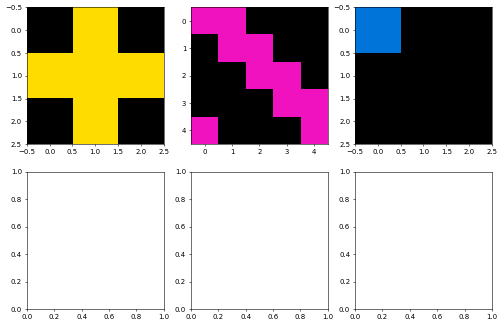

In [295]:
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

fig, axs = plt.subplots(2, len(correct), figsize=(4*len(correct),8), dpi=50)
for n, i in enumerate(correct):
    axs[0][n].imshow(i, cmap=cmap, norm=norm)
plt.show()

In [289]:
len(correct)

3

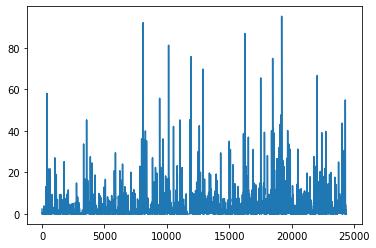

In [365]:
plt.plot(history)